In [136]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [52]:
def show_image_plt(img_rgb):
    #rgb_carrot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(5000)
    cv2.destroyAllWindows()

***height (rows), width(cols)***

In [7]:
def resize_image(vegi):
    height, width, c = vegi.shape
    new_height = 100
    ratio = new_height / height 
    new_width = int(width * ratio)
    dimensions = (new_width, new_height)
    print(dimensions)
    resized_img = cv2.resize(vegi, dimensions, interpolation=cv2.INTER_LINEAR)
    print("New shape:      ", resized_img.shape)

    return resized_img

# current values for borders they roughly fit to the real hsv values. I test it for brown onion, carrot, brown potato with
# white background, respectively
def mask_image(img_hsv, img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_hsv, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    #plt.subplot(1, 3, 1)
    #plt.imshow(img_rgb)
    #plt.subplot(1, 3, 2)
    #plt.imshow(mask, cmap='gray')
    #plt.subplot(1, 3, 3)
    #plt.imshow(result)
    #plt.show()
    return mask, result
    

def resize_to_square(vegi):
    img_size = 256
    height, width = vegi.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        crop_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        crop_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        crop_img = r_img[0:img_size, 0:img_size]

    if(crop_img.shape[0] != img_size or crop_img.shape[1] != img_size):
        crop_img = r_img[0:img_size, 0:img_size]

    return crop_img


def flip_image_and_show(img):
    # flip vertical
    img_v = cv2.flip(img, 0)
    #show_image_plt(onion_sq_v)

    #flip horizontal
    img_h = cv2.flip(img, 1)
    #show_image_plt(onion_sq_h)

    #flip vertical + horizontal
    img_vh = cv2.flip(img, -1)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #1 row, 3 cols
    fig.tight_layout(h_pad=4)
    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_v)
    axarr[0][1].set_title("Flip Vertical")
    axarr[1][0].imshow(img_h)
    axarr[1][0].set_title("Flip Horizontal")
    axarr[1][1].imshow(img_vh)
    axarr[1][1].set_title("Flip Vertical + Horizontal")
    fig.suptitle('Flipped Images')
    plt.subplots_adjust(top = 0.85)


def rotate_image_and_show(img):
    # rotate 90 degree clockwise
    img_r90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    #show_image_plt(onion_sq_v)

    #rotate 180 degree
    img_r180 = cv2.rotate(img, cv2.ROTATE_180)
    #show_image_plt(onion_sq_h)

    #rotate 90 degree counterclockwise
    img_rcw90 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    #show_image_plt(onion_sq_vh)

    fig, axarr = plt.subplots(2, 2) #2 row, 2 cols
    fig.tight_layout(h_pad=4)

    axarr[0][0].imshow(img)
    axarr[0][0].set_title("Original")
    axarr[0][1].imshow(img_r90)
    axarr[0][1].set_title("+ 90")
    axarr[1][0].imshow(img_r180)
    axarr[1][0].set_title("+ 180")
    axarr[1][1].imshow(img_rcw90)
    axarr[1][1].set_title("- 90")

    fig.suptitle('Rotated Images')
    plt.subplots_adjust(top = 0.85)


def draw_bounding_box(img, low_threshold, high_threshold):
    # the thresholds are used as gradients thresholds. 
    # Something like, gradients smaller than the low_threshold or between the thresholds are ignored 
    result = img.copy()
    gray_square_onion = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_square_onion, low_threshold, high_threshold, cv2.THRESH_BINARY)[1]

    # get contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        # The idea is only keep bigger bounding boxes. Probably it presents the object
        if w > 22 and h > 0.5:
            cv2.rectangle(result, (x, y), (x+w, y+h), (100, 0, 255), 1)
            ROI = img[y:y+h, x:x+w]
            print(f"ROI:. Size of Bounding Box: w = {w} / h = {h}")
        else:
            continue
    show_image_plt(result)


def plot_color_space_rgb_to_hsv(img_rgb, convert_to_hsv=True):
    copy_rgb = img_rgb.copy()
    img_hsv = copy_rgb
    x_label = "R (X)"
    y_label = "G (Y)"
    z_label = "B (Z)"

    if convert_to_hsv:
        img_hsv = cv2.cvtColor(copy_rgb, cv2.COLOR_RGB2HSV)
        x_label = "Hue X"
        y_label = "Saturation Y"
        z_label = "Value Z"

    pixel_colors = copy_rgb.reshape((np.shape(copy_rgb)[0]*np.shape(copy_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    x, y, z = cv2.split(img_hsv)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(x.flatten(), y.flatten(), z.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_zlabel(z_label)
    plt.show()


def print_color_values(img):
    for row in range(0, img.shape[1]):
        for col in range(0, img.shape[1]):
            print(f"Row {row}: Spalte {col} {img[row, col]}")

def kMeans(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_hsv.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

#Expect gray img
def min_area_rect(img_rgb, low_thresh, high_thresh):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #gray = img_rgb.copy()
    #gray = cv2.blur(gray, (3,3))

    #plt.imshow(gray, cmap='gray')
    #plt.show()

    # Use Otsu's method to calculate a dynamic threshold
    #a, thresh = cv2.threshold(gray, low_thresh, high_thresh, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #print(thresh.min(), thresh.max())
    #thresh_low = 0.5 * thresh
    #thresh_high = 1.5 * thresh
    # Apply edge detection using the dynamic threshold
    edges = cv2.Canny(gray, low_thresh, high_thresh)
    
    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print('Length Contours: ', len(contours))
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    #print(contours)
    # Get the rotated bounding box of the contour
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    
    # Draw the rotated bounding box on the original image
    result_image = img_rgb.copy()
    cv2.drawContours(result_image, [box], 0, (0, 255, 0), 2)
    thres = 10
    return result_image, thres, box

def get_object_color(center, cluster_img_hsv):
    for point in center:
        edge_point = 0
        if (point == cluster_img_hsv[0][0]).all():
            edge_point += 1

        if (point == cluster_img_hsv[0][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][255]).all():
            edge_point += 1

        if (point == cluster_img_hsv[255][0]).all():
            edge_point += 1

        if edge_point >= 3:
            #print(f"Color Background found: {point}")
            pass

        if edge_point < 3:
            #print(f"Color Object found: {point}")
            return point

https://realpython.com/python-opencv-color-spaces/

The Code below is for data augmentation. It is a technique for enlarging a dataset.
It will use the standard techniques like horizontal & vertical flipping and rotation.

Load Images from personal cloud storage

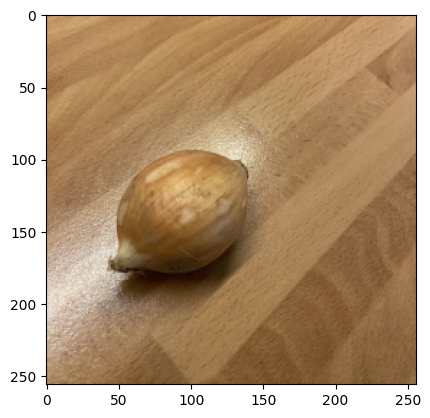

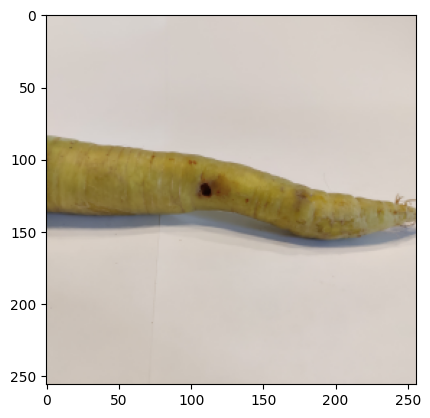

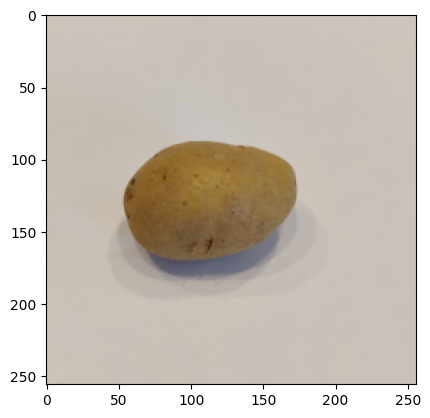

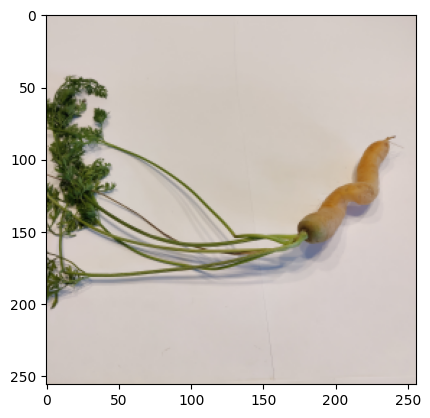

In [4]:
path = "G:\Meine Ablage\Images_AI_Project\zwiebel_jpg\zwiebel_1.jpg"
onion = cv2.imread(path.replace("\\","/"))
onion = cv2.cvtColor(onion, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\KI_Projekt\Bilder\Karotte\karotte_107.jpg"
carrot = cv2.imread(path.replace("\\","/"))
carrot = cv2.cvtColor(carrot, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\karotte_jpg\karotte_trieb_13.jpg"
carrot_trieb = cv2.imread(path.replace("\\","/"))
carrot_trieb = cv2.cvtColor(carrot_trieb, cv2.COLOR_BGR2RGB)

path = "G:\Meine Ablage\Images_AI_Project\kartoffel_jpg\kartoffel_122.jpg"
potato = cv2.imread(path.replace("\\","/"))
potato = cv2.cvtColor(potato, cv2.COLOR_BGR2RGB)

onion_sq = resize_to_square(onion)
carrot_sq = resize_to_square(carrot)
potato_sq = resize_to_square(potato)
carrot_trieb_sq = resize_to_square(carrot_trieb)

show_image_plt(onion_sq)
show_image_plt(carrot_sq)
show_image_plt(potato_sq)
show_image_plt(carrot_trieb_sq)

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

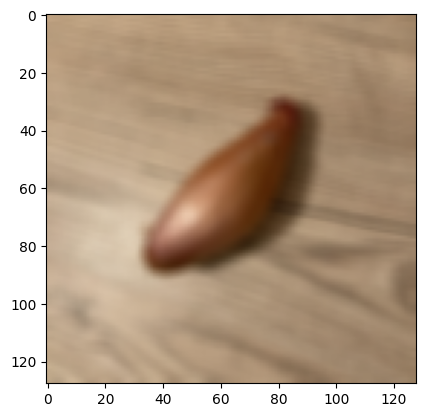

In [9]:
# Creates a 1-D Gaussian kernel
a = cv2.getGaussianKernel(5,5)

# Apply the above Gaussian kernel. Here, I
# have used the same kernel for both X and Y
b = cv2.sepFilter2D(onion_sq,-1,a,a)
show_image_plt(b)

https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/

In [14]:
cv2.TERM_CRITERIA_EPS
cv2.TERM_CRITERIA_MAX_ITER

1

In [5]:
def kMeans_for_rgb_img(img_rgb, number_of_clusters, attempts):
    # KMeans Processing
    #img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    K = number_of_clusters
    onion_2D = img_rgb.reshape((-1,3)) #Reshape to 2 dimensional image (65536, 3)
    onion_2D = np.float32(onion_2D)

    CONSTANT_1 = 10
    CONSTANT_2 = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, CONSTANT_1, CONSTANT_2)

    ret, label, center=cv2.kmeans(onion_2D, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img_rgb.shape))

    return result_image, label, center

def mask_image_rgb(img_rgb, border_low=(8, 50, 75), border_high=(15, 255, 160)):
    #15, 23, 135
    mask = cv2.inRange(img_rgb, border_low, border_high)
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.show()
    return mask, result


In [8]:
def run_kmeans(orig_img):
    median_rgb = cv2.medianBlur(orig_img, 9)
    show_image_plt(median_rgb)

    #gaussian_onion = cv2.GaussianBlur(onion_sq,(5,5),0)
    #show_image_plt(gaussian_onion)

    clusterd_img_hsv, label, center = kMeans(median_rgb, number_of_clusters=2, attempts=100)
    plt.imshow(clusterd_img_hsv)
    plt.show()

    return center, clusterd_img_hsv, median_rgb

def run_bounding_box(clusterd_img_hsv, median_rgb, center_object, t_low, t_high):
    masked_img_gray, masked_img_rgb = mask_image(clusterd_img_hsv, median_rgb, border_low=center_object, border_high=center_object) #borders for hsv colorspace
    #print(masked_img_gray)
    result_image, thresh, box = min_area_rect(masked_img_rgb, t_low, t_high)

    plt.imshow(result_image)
    plt.show()

https://docs.opencv.org/4.x/de/d62/tutorial_bounding_rotated_ellipses.html

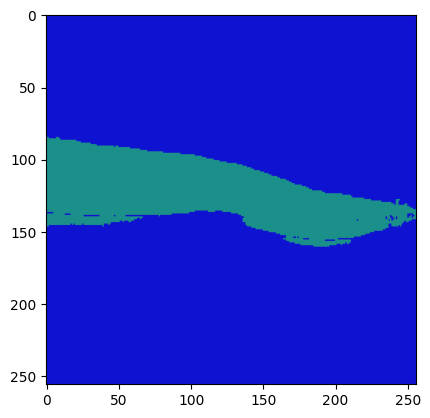

CENTER:  [[ 27 143 137]
 [ 15  18 209]]


In [9]:
centers, clusterd_img_hsv, median_rgb = run_kmeans(carrot_sq)
print("CENTER: ", centers)
#center_object = get_object_color(centers, clusterd_img_hsv)

In [10]:
clusterd_img_hsv[0][0]

array([ 15,  18, 209], dtype=uint8)

Length Contours:  16


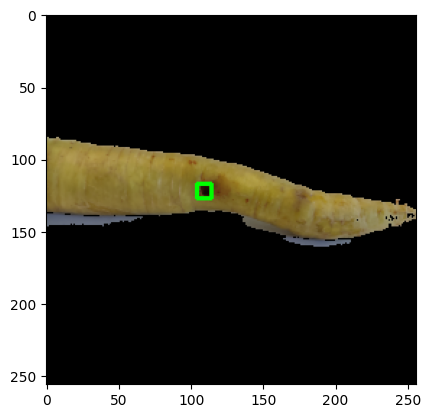

In [11]:
#for val in range(75, 130):
#print("Thres: ", val)
val = 110
run_bounding_box(clusterd_img_hsv, median_rgb, centers[0], val, val*2)

In [224]:
# Find correct center. Assumption: Min 3 Corner points of the image should be part of background
print("Background: ", clusterd_img_hsv[0][0])
print("Object: ", clusterd_img_hsv[100][50])

for point in center:
    edge_point = 0
    if (point == clusterd_img_hsv[0][0]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[0][255]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[255][255]).all():
        edge_point += 1

    if (point == clusterd_img_hsv[255][0]).all():
        edge_point += 1

    if edge_point >= 3:
        print(f"Color Background found: {point}")

    if edge_point < 3:
        print(f"Color Object found: {point}")


Background:  [ 14  23 208]
Object:  [ 15 183 129]
Color Background found: [ 14  23 208]
Color Object found: [ 15 183 129]


In [290]:
def thresh_callback(val, src_gray):
    #print(val)
    threshold = val
    #global src_gray
    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    minEllipse = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv2.minAreaRect(c)
        #if c.shape[0] > 5:
        #    minEllipse[i] = cv2.fitEllipse(c)

    # Draw contours + rotated rects + ellipses

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i, c in enumerate(contours):
        #color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        color = (0, 255, 0)
        # contour
        #cv2.drawContours(drawing, contours, i, color)
        # ellipse
        #if c.shape[0] > 5:
        #    cv2.ellipse(drawing, minEllipse[i], color, 2)
        # rotated rectangle
        box = cv2.boxPoints(minRect[i])
        box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        cv2.drawContours(drawing, [box], 0, color)
    
    plt.imshow(drawing)
    plt.show()
    #cv2.imshow('Contours', drawing)
    #cv2.waitKey()
    #cv2.destroyAllWindows()

Approach: https://stackoverflow.com/questions/72100376/opencv-how-to-draw-a-rotated-bounding-box-in-python

compute dynamically thresholds: https://stackoverflow.com/questions/24862374/canny-edge-detector-threshold-values-gives-different-result

In [283]:
#path = "G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_9.jpg"
#vegi = cv2.imread(path.replace("\\","/")) # As BGR

def draw_contours(bgr_img, object_area=500):
    img_256 = resize_to_square(bgr_img)
    #gray = cv2.cvtColor(img_256, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img_256, cv2.COLOR_BGR2HSV)

    hue, saturation, value = cv2.split(hsv)

    blurred_sat = cv2.GaussianBlur(saturation, (5, 5), 0)

    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    thresh_low = 0.3 * thresh 
    thresh_high = 2 * thresh
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)

    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=6) 
    #show_image_plt(dilate)

    erode = cv2.erode(dilate, kernel, iterations=4)
    #show_image_plt(erode)

    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # ???
   
    img_256_copy = img_256.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(img_256_copy, [box], 0, (0, 255, 0), 2)
            
            #print("Draw Contour")
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True

    rgb = cv2.cvtColor(img_256_copy, cv2.COLOR_BGR2RGB)
    return rgb, more_than_one_box, box

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)

    return h, w


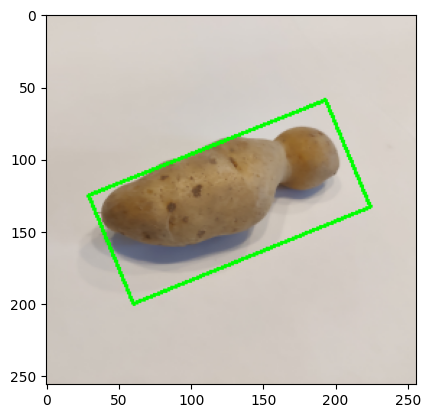

Height: 176.78. width: 80.23


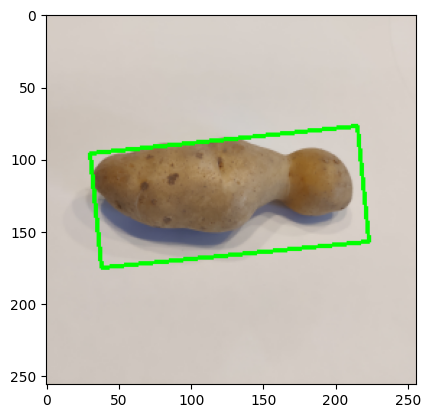

Height: 185.97. width: 80.4


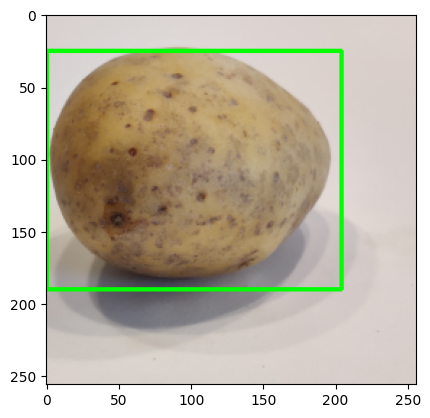

Height: 204.0. width: 165.0


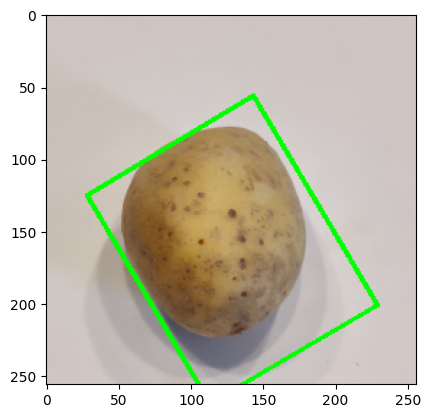

Height: 168.59. width: 134.11


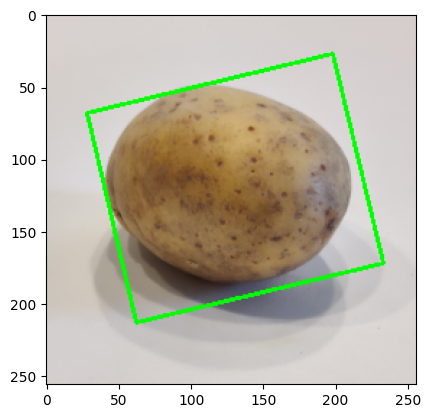

Height: 174.87. width: 149.16


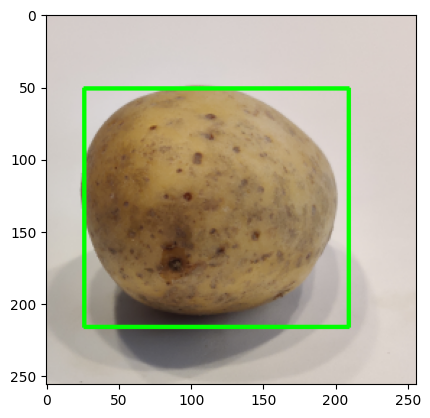

Height: 183.0. width: 165.0


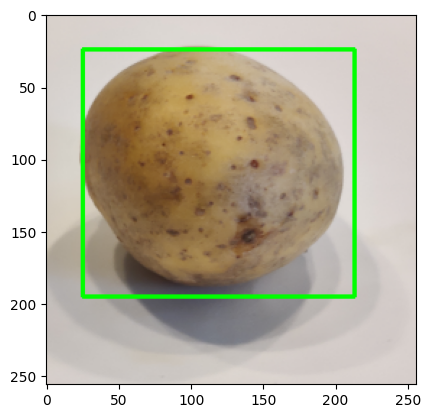

Height: 188.0. width: 171.0


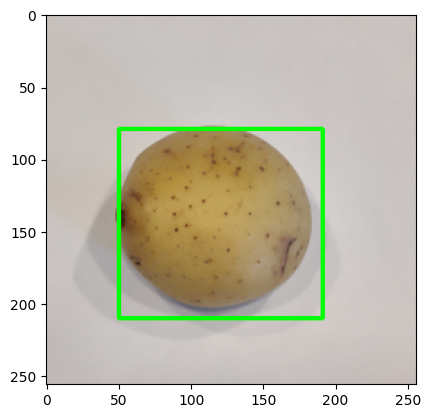

Height: 141.0. width: 131.0


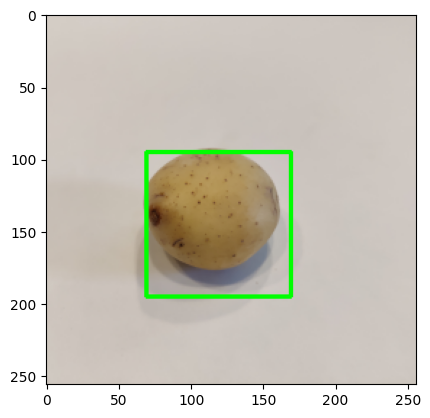

Height: 100.0. width: 100.0


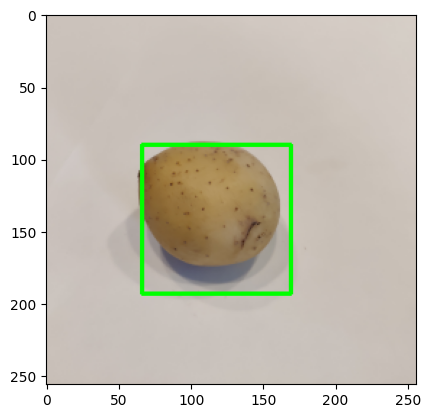

Height: 103.0. width: 103.0


In [286]:
paths = [f"G:\Meine Ablage\KI_Projekt\Bilder\Kartoffel\kartoffel_{i}.jpg" for i in range(40, 50)]
for path in paths:
    vegi = cv2.imread(path.replace("\\","/")) # As BGR
    rgb, more_than_one_box, box = draw_contours(vegi)
    if more_than_one_box:
        box_size = 500
        while more_than_one_box:
            print("Increase Box Size by 250")
            box_size += 250
            rgb, more_than_one_box, box = draw_contours(vegi, box_size)

    show_image_plt(rgb)

    heigth, width = get_size_box(box)
    print(f"Height: {heigth}. width: {width}")

In [241]:
for _ in range(0, 2):
    arr5 = np.zeros((3, 2)) 
    for _ in range(0, 3):
        arr1 = np.array([[1,2], [3, 4], [5,6]])
        arr1 = arr1 + _*10
        arr5 = np.append(arr5, arr1, axis=0)

arr5


array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  2.],
       [ 3.,  4.],
       [ 5.,  6.],
       [11., 12.],
       [13., 14.],
       [15., 16.],
       [21., 22.],
       [23., 24.],
       [25., 26.]])